In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [128]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print("MAE train:", mae_train)
    print("MAE test:", mae_test)
    print("RMSE train:", rmse_train)
    print("RMSE test:", rmse_test)
    print("R2 train:", r2_train)
    print("R2 test:", r2_test)

In [129]:
df = pd.read_csv('../data/raw_data/btc.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df = df.loc['2019-01-01':'2024-12-31']

# Technical indicators

In [130]:
cols = ['sma_7', 'sma_21', 'sma_50', 'sma_200']
for col in cols:
    df[col] = df['close'].rolling(window=int(col.split('_')[1]), min_periods=1).mean()

In [131]:
cols = ['ema_7', 'ema_21', 'ema_50', 'ema_200']
for col in cols:
    df[col] = df['close'].ewm(span=int(col.split('_')[1]), adjust=False).mean()

In [132]:
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()

In [133]:
high_low = df['high'] - df['low']
high_close = np.abs(df['high'] - df['close'].shift(1))
low_close = np.abs(df['low'] - df['close'].shift(1))

In [134]:
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['atr'] = true_range.ewm(span=14, adjust=False).mean()
up_move = df['high'] - df['high'].shift(1)
down_move = df['low'].shift(1) - df['low']

In [135]:
df['plus_dm'] = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
df['minus_dm'] = np.where((down_move > up_move) & (down_move > 0), down_move, 0)

In [136]:
plus_dm_smooth = df['plus_dm'].ewm(span=14, adjust=False).mean()
minus_dm_smooth = df['minus_dm'].ewm(span=14, adjust=False).mean()

In [137]:
df['plus_di'] = 100 * (plus_dm_smooth / df['atr'])
df['minus_di'] = 100 * (minus_dm_smooth / df['atr'])

In [138]:
di_sum = df['plus_di'] + df['minus_di']
df['dx'] = 100 * np.abs(df['plus_di'] - df['minus_di']) / np.where(di_sum == 0, np.nan, di_sum)
df['adx'] = df['dx'].ewm(span=14, adjust=False).mean()

In [139]:
drop_cols = ['plus_dm', 'minus_dm', 'plus_di', 'minus_di', 'dx']
df = df.drop(drop_cols, axis=1)

In [140]:
hl2 = (df['high'] + df['low']) / 2

In [141]:
df['upper_band'] = hl2 + (3 * df['atr'])
df['lower_band'] = hl2 - (3 * df['atr'])

In [142]:
df['supertrend'] = np.nan
in_uptrend = True

In [143]:
for i in range(1, len(df)):
    prev_supertrend = df['supertrend'].iloc[i - 1]


    if df['close'].iloc[i] > df['upper_band'].iloc[i - 1]:
        in_uptrend = True
    elif df['close'].iloc[i] < df['lower_band'].iloc[i - 1]:
        in_uptrend = False


    if in_uptrend:
        df.loc[df.index[i], 'supertrend'] = max(df['lower_band'].iloc[i], prev_supertrend if prev_supertrend is not np.nan else df['lower_band'].iloc[i])
    else:
        df.loc[df.index[i], 'supertrend'] = min(df['upper_band'].iloc[i], prev_supertrend if prev_supertrend is not np.nan else df['upper_band'].iloc[i])


In [144]:
df.drop(columns=['upper_band', 'lower_band'], inplace=True)

# Momentum Indicators

In [145]:
delta = df['close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / (loss + 1e-10)
df['rsi'] = 100 - (100 / (1 + rs))

In [146]:
df['stoch_k'] = 100 * (df['close'] - df['low'].rolling(14).min()) / (df['high'].rolling(14).max() - df['low'].rolling(14).min() + 1e-10)
df['stoch_d'] = df['stoch_k'].rolling(3).mean()

In [147]:
df['williams_r'] = -100 * ((df['high'].rolling(14).max() - df['close']) / (df['high'].rolling(14).max() - df['low'].rolling(14).min() + 1e-10))

In [148]:
tp = (df['high'] + df['low'] + df['close']) / 3
mean_dev = lambda x: np.mean(np.abs(x - x.mean()))
df['cci'] = (tp - tp.rolling(20).mean()) / (0.015 * tp.rolling(20).apply(mean_dev, raw=True))

In [149]:
sma = df['close'].rolling(14).mean()
std = df['close'].rolling(14).std()
df['boll_upper'] = sma + (2 * std)
df['boll_lower'] = sma - (2 * std)

In [150]:
df['hist_vol'] = df['close'].pct_change().rolling(14).std() * np.sqrt(252)

In [151]:
df['donchian_high'] = df['high'].rolling(20).max()
df['donchian_low'] = df['low'].rolling(20).min()

In [152]:
df['obv'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()

In [153]:
money_flow_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'] + 1e-10)
money_flow_volume = money_flow_multiplier * df['volume']
df['cmf'] = money_flow_volume.rolling(20).sum() / df['volume'].rolling(20).sum()

In [154]:
df['vwap'] = (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()

# Arithmetic and transformation

In [155]:
df['log_close'] = np.log(df['close'])

In [156]:
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['simple_return'] = df['close'].pct_change()
df['log_momentum'] = np.log(df['close']) - np.log(df['close'].shift(5))
df['price_zscore'] = (df['close'] - df['close'].rolling(window=14).mean()) / \
                         (df['close'].rolling(window=14).std() + 1e-10)

In [157]:
df['log_volume'] = np.log(df['volume'] + 1e-10)
df['volume_zscore'] = (df['volume'] - df['volume'].rolling(window=14).mean()) / \
                          (df['volume'].rolling(window=14).std() + 1e-10)
df['vol_price_ratio'] = df['volume'] / (df['close'].diff().abs() + 1e-10)

In [158]:
df['roc_volatility'] = df['hist_vol'].pct_change()
df['hist_vol'] = df['log_return'].rolling(window=14).std() * np.sqrt(252)
df['roc_volatility'] = df['hist_vol'].pct_change()
df['roc_volume'] = df['volume'].pct_change()

In [159]:
columns_to_lag = ['close', 'volume', 'rsi', 'macd', 'atr', 'adx']
lags = [1, 2, 3]

In [160]:
for col in columns_to_lag:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

In [161]:
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

In [162]:
windows = [5, 10, 20, 50]
for window in windows:
    df[f'log_return_ma_{window}'] = df['log_return'].rolling(window=window).mean()

In [163]:
df = df.loc['2020-01-01':'2024-12-31']

In [164]:
df.isna().sum().sum()

0

In [165]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df.describe()

,open,high,low,close,volume,sma_7,sma_21,sma_50,sma_200,ema_7,ema_21,ema_50,ema_200,macd,signal,atr,adx,supertrend,rsi,stoch_k,stoch_d,williams_r,cci,boll_upper,boll_lower,hist_vol,donchian_high,donchian_low,obv,cmf,vwap,log_close,log_return,simple_return,log_momentum,price_zscore,log_volume,volume_zscore,vol_price_ratio,roc_volatility,roc_volume,close_lag1,close_lag2,close_lag3,volume_lag1,volume_lag2,volume_lag3,rsi_lag1,rsi_lag2,rsi_lag3,macd_lag1,macd_lag2,macd_lag3,atr_lag1,atr_lag2,atr_lag3,adx_lag1,adx_lag2,adx_lag3,log_return_ma_5,log_return_ma_10,log_return_ma_20,log_return_ma_50
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,36256.876650,37112.128533,35359.703810,36304.237718,84424.512317,36162.080827,35815.381859,35093.586058,32488.348751,36160.724066,35815.733293,35155.027385,32599.946667,343.250980,342.353140,1739.975866,37.194613,38305.086512,53.810393,56.100303,56.127706,-43.899697,18.286471,39207.128978,32776.128415,0.488266,39806.598911,31602.620005,1.371883e+06,0.077284,19798.488592,10.301061,0.001404,0.001998,0.006999,0.190326,10.970377,-0.009934,1710.860207,0.007362,0.109595,36256.957603,36210.134368,36162.871117,84427.983812,84429.071107,84438.819931,53.831795,53.850735,53.865409,343.589557,343.838013,343.921310,1738.060654,1736.191099,1734.312292,37.190548,37.187102,37.184680,0.001400,0.001407,0.001431,0.001400
std,21084.475307,21559.099335,20600.051669,21116.123701,91573.040113,20973.230136,20596.292702,19733.131654,17292.369237,20944.866640,20508.163742,19641.944516,16727.448000,1590.002480,1514.296266,1194.861501,14.143431,21680.708102,17.755880,28.333075,26.454435,28.333075,115.061953,22594.114844,19189.724880,0.254562,22727.744091,18387.303362,2.160136e+06,0.132144,6472.840883,0.674113,0.034697,0.034038,0.075692,1.255144,0.817774,1.010700,25973.311025,0.142237,0.562021,21084.500848,21053.847810,21021.531404,91570.701944,91570.038830,91563.439341,17.745622,17.731884,17.722609,1589.851680,1589.754017,1589.729021,1194.457168,1194.108672,1193.726693,14.144990,14.146137,14.147161,0.015138,0.010877,0.007898,0.005311
min,4800.010000,5365.420000,3782.130000,4800.000000,7308.955420,5235.230000,5979.630952,6674.473000,7970.825550,5672.180259,6544.861232,7124.231127,7860.463590,-5073.278718,-4435.851793,152.111634,13.540053,7736.080642,6.289216,0.248844,2.541840,-99.751156,-511.950377,6938.214189,3416.799575,0.085700,6957.960000,3782.130000,-3.852503e+06,-0.314284,7745.875314,8.476371,-0.502607,-0.395048,-0.615935,-3.271189,8.896856,-2.466072,5.825280,-0.563649,-0.804273,4800.000000,4800.000000,4800.000000,7308.955420,7308.955420,7308.955420,6.289216,6.289216,6.289216,-5073.278718,-5073.278718,-5073.278718,152.111634,152.111634,152.111634,13.540053,13.540053,13.540053,-0.123187,-0.061915,-0.035057,-0.014205
25%,19580.470000,20144.220000,19158.210000,19610.295000,33626.828065,19744.062857,19675.870714,19598.717600,19717.751000,19764.636178,19691.822728,19927.855291,21552.613495,-461.972826,-422.397420,722.953812,26.469912,20599.023799,41.432064,31.112152,33.043232,-68.887848,-67.805689,21505.109878,18187.594941,0.329614,21603.725000,17622.000000,-6.427062e+05,-0.016748,15486.504959,9.883810,-0.013052,-0.012967,-0.029007,-0.803530,10.423079,-0.748948,45.408244,-0.023324,-0.239523,19580.955000,19563.005000,

In [166]:
skew = df.skew()
print(skew[abs(skew) > 0.5].sort_values(ascending=False))

vol_price_ratio     33.357408
roc_volatility       7.793655
hist_vol             3.419952
volume_lag3          2.860530
volume_lag2          2.860084
volume_lag1          2.860044
volume               2.859888
roc_volume           2.424479
adx_lag3             0.801052
adx_lag2             0.800808
adx_lag1             0.800364
adx                  0.799912
atr_lag3             0.740398
atr_lag2             0.738415
atr_lag1             0.736438
atr                  0.734535
boll_lower           0.712998
donchian_low         0.709128
volume_zscore        0.699975
low                  0.685432
close                0.669982
open                 0.667311
close_lag1           0.667306
close_lag2           0.664854
close_lag3           0.662028
high                 0.656380
sma_7                0.654874
ema_7                0.650667
macd                 0.630345
macd_lag1            0.630020
macd_lag2            0.629742
macd_lag3            0.629629
signal               0.620276
sma_21    

# Testing

In [167]:
correlation_matrix = df.corr()
low_correlation_features = correlation_matrix[abs(correlation_matrix['log_close']) < 0.01].index.tolist()
if 'log_close' in low_correlation_features:
	low_correlation_features.remove('log_close')

In [168]:
df = df.drop(low_correlation_features, axis=1)
print(f'Features removed: {low_correlation_features}')

Features removed: ['adx', 'cci', 'price_zscore', 'adx_lag1', 'adx_lag2', 'adx_lag3']


In [169]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [171]:
X_train = np.log1p(X_train)
X_test = np.log1p(X_test)

c:\Users\santi\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [172]:
boxcox_vars = ['hist_vol', 'roc_volatility', 'vol_price_ratio']
lambdas = {}

for var in boxcox_vars:
    X_train[var], lambdas[var] = boxcox(X_train[var] + 1)
    X_test[var] = boxcox(X_test[var] + 1, lmbda=lambdas[var])

In [173]:
pt = PowerTransformer(method='yeo-johnson')
cols_neg_skew = ['log_return', 'simple_return', 'volume_zscore', 'obv', 'log_momentum']
X_train[cols_neg_skew] = pt.fit_transform(X_train[cols_neg_skew])
X_test[cols_neg_skew] = pt.transform(X_test[cols_neg_skew])

In [174]:
new_skew = X_train.skew()
print(new_skew[abs(new_skew) > 0.5].sort_values(ascending=False))

roc_volatility      0.732622
volume_lag2         0.510329
volume_lag3         0.510283
volume_lag1         0.509560
volume              0.509226
high               -0.503256
sma_21             -0.507488
ema_21             -0.511997
close_lag3         -0.514535
sma_7              -0.514690
ema_7              -0.515268
close_lag2         -0.516351
close_lag1         -0.518030
open               -0.518059
ema_50             -0.520636
low                -0.543544
boll_lower         -0.593835
ema_200            -0.641192
log_return_ma_10   -0.658311
donchian_low       -0.666396
vwap               -0.859384
rsi                -0.867171
rsi_lag1           -0.867477
rsi_lag2           -0.868218
rsi_lag3           -0.868679
williams_r         -0.906834
stoch_d            -0.991777
log_return_ma_5    -1.072587
macd_lag3          -1.168278
macd_lag2          -1.169450
macd_lag1          -1.170174
macd               -1.170453
signal             -1.295845
stoch_k            -1.394389
dtype: float64

In [175]:
skew_y = y_train.skew()
print(skew_y[abs(skew_y) > 0.5])

[-0.51969775]


In [176]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [177]:
y_pred_train = model.predict(X_train)
y_pred_train = pd.Series(y_pred_train, index=y_train.index)
y_pred_test = model.predict(X_test)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)

In [178]:
evaluate_model(y_pred_train, y_pred_test, y_train, y_test)

MAE train: 0.0021133739047038283
MAE test: 0.07676696335265125
RMSE train: 0.0027529541039859142
RMSE test: 0.1530568726876263
R2 train: 0.9999794866981692
R2 test: 0.498051255091867


In [179]:
def plot_predictions(y_test_real, y_pred_test):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test, label="Predicted", color="orange")
    plt.legend()
    plt.show()

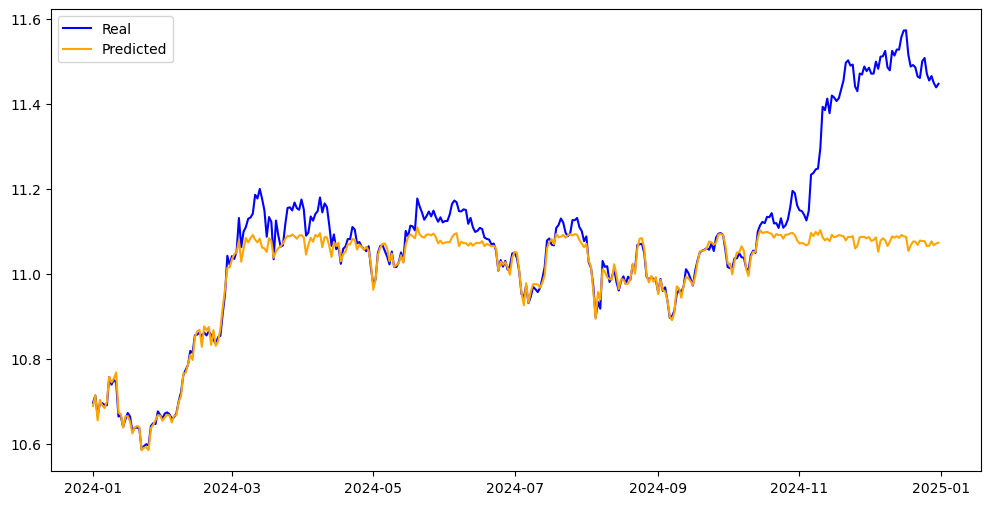

In [180]:
plot_predictions(y_test, y_pred_test)

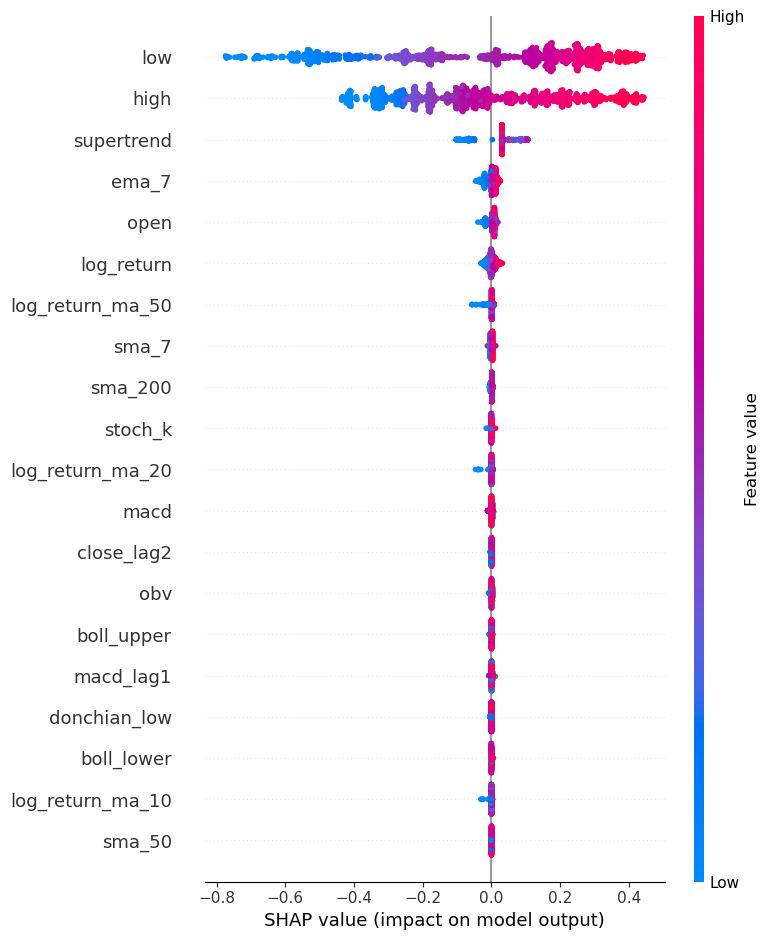

In [181]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
threshold = 0.01

In [183]:
selected_features = np.array(X_train.columns)[mean_abs_shap > threshold]
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [184]:
X_train['range'] = X_train['high'] - X_train['low']
X_test['range'] = X_test['high'] - X_test['low']
X_train['midpoint'] = (X_train['high'] + X_train['low']) / 2
X_test['midpoint'] = (X_test['high'] + X_test['low']) / 2

In [185]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [186]:
y_pred_train = model.predict(X_train)
y_pred_train = pd.Series(y_pred_train, index=y_train.index)
y_pred_test = model.predict(X_test)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)

In [187]:
evaluate_model(y_pred_train, y_pred_test, y_train, y_test)

MAE train: 0.00702533276599673
MAE test: 0.07655565051395657
RMSE train: 0.009032424185409444
RMSE test: 0.14991475174356253
R2 train: 0.9997791759971705
R2 test: 0.5184488308500674


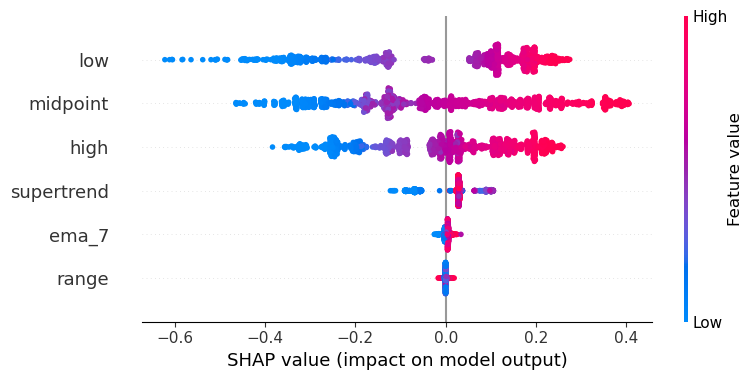

In [190]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

In [192]:
mean_abs_shap_filtered = np.abs(shap_values.values).mean(axis=0)

In [193]:
pca_features = np.array(X_train.columns)[mean_abs_shap_filtered <= threshold]

In [194]:
if len(pca_features) > 0:
    scaler = StandardScaler()
    X_train_pca_scaled = scaler.fit_transform(X_train[pca_features])
    X_test_pca_scaled = scaler.transform(X_test[pca_features])

    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_pca_scaled)
    X_test_pca = pca.transform(X_test_pca_scaled)

    pca_columns = [f'PCA_{i}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
    X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)
    X_train_final = pd.concat([X_train, X_train_pca_df], axis=1)
    X_test_final = pd.concat([X_test, X_test_pca_df], axis=1)
else:
    X_train_final = X_train
    X_test_final = X_test

print(f'Original features: {X_train.shape[1]}')
print(f'PCA features: {X_train_pca.shape[1] if len(pca_features) > 0 else 0}')

Original features: 6
PCA features: 2


In [195]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [196]:
model.fit(X_train_final, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [197]:
y_pred_train = model.predict(X_train_final)
y_pred_train = pd.Series(y_pred_train, index=y_train.index)
y_pred_test = model.predict(X_test_final)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)

In [198]:
evaluate_model(y_pred_train, y_pred_test, y_train, y_test)

MAE train: 0.006459036941205281
MAE test: 0.07790964669551265
RMSE train: 0.008236502826000488
RMSE test: 0.15104097795131669
R2 train: 0.9998163785842241
R2 test: 0.5111864010556872
